In [198]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

In [199]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [200]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-5-hcv.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [201]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

ALP           2.926829
CHOL          1.626016
ALB           0.162602
ALT           0.162602
PROT          0.162602
Unnamed: 0    0.000000
Category      0.000000
Age           0.000000
Sex           0.000000
AST           0.000000
BIL           0.000000
CHE           0.000000
CREA          0.000000
GGT           0.000000
dtype: float64

In [202]:
mean_imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

data[['ALP','CHOL','ALB','ALT','PROT']] = mean_imp.fit_transform(data[['ALP','CHOL','ALB','ALT','PROT']])

In [203]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

Unnamed: 0    0.0
Category      0.0
Age           0.0
Sex           0.0
ALB           0.0
ALP           0.0
ALT           0.0
AST           0.0
BIL           0.0
CHE           0.0
CHOL          0.0
CREA          0.0
GGT           0.0
PROT          0.0
dtype: float64

In [204]:
data.duplicated().sum()

data.drop_duplicates(inplace=True, ignore_index=False, subset=None, keep='first')

data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

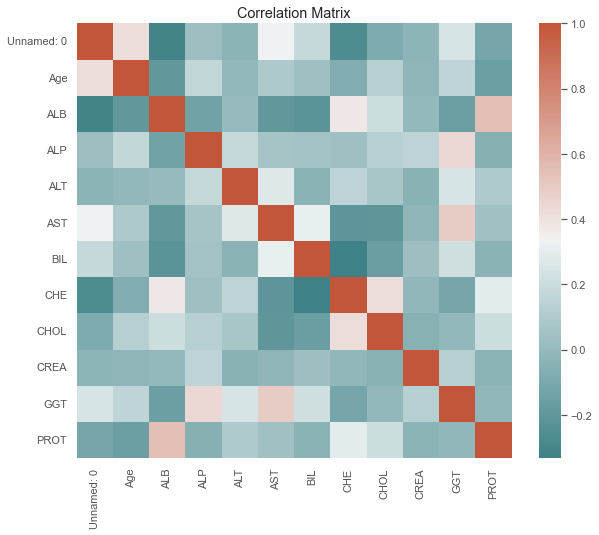

In [205]:
f,ax = plt.subplots(figsize=(10,8))

data_corr = data.corr()

ax.set_title('Correlation Matrix')
sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_),cmap=sns.diverging_palette(200,20, as_cmap=True), ax=ax, square=True)

In [206]:
le = LabelEncoder()
data.drop(columns=['Unnamed: 0'], inplace=True)

y = data.Category

y_true = le.fit_transform(y)

data = pd.get_dummies(data,dtype=float)
data

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category_0=Blood Donor,Category_0s=suspect Blood Donor,Category_1=Hepatitis,Category_2=Fibrosis,Category_3=Cirrhosis,Sex_f,Sex_m
0,32,38.5,52.50000,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32,38.5,70.30000,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32,46.9,74.70000,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,32,43.2,52.00000,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32,39.2,74.10000,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,62,32.0,416.60000,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0
611,64,24.0,102.80000,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,0.0,0.0,0.0,0.0,1.0,1.0,0.0
612,64,29.0,87.30000,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
613,46,33.0,68.28392,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [207]:
le.classes_ 

n_clusters = len(le.classes_)

In [208]:
preprocessor = Pipeline( 
    [ 
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=2, random_state=42))
    ]
)



In [209]:
clusterer = Pipeline( 
    [ 
        (
        'kmeans',
        KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            n_init=50,
            max_iter=500,
            random_state=42,
        )
        )
    ]
)

In [210]:
pipe = Pipeline(
  [
       ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
   )

In [211]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [212]:
preprocessed_data = pipe['preprocessor'].transform(data)

predicted_labels = pipe['clusterer']['kmeans'].labels_

In [213]:
# data['predicted_labels'] = predicted_labels
# data

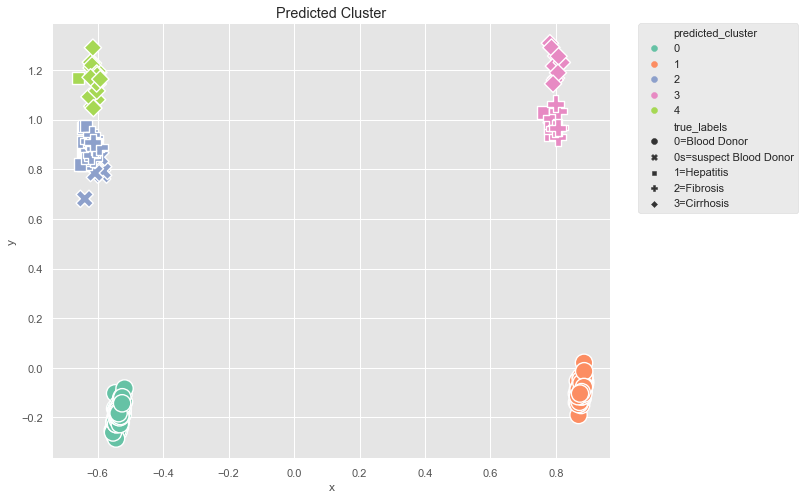

In [214]:
pcdaf = pd.DataFrame( 
    
        preprocessed_data, columns=['x', 'y']
    
)

pcdaf['predicted_cluster'] = predicted_labels
pcdaf['true_labels'] = le.inverse_transform(y_true)

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Predicted Cluster')

scatt = sns.scatterplot( 
    data = pcdaf,
    s=300,
    x='x',
    y='y',
    hue='predicted_cluster',
    style='true_labels',
    palette='Set2',
)

scatt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.0)